By [Kevin Michalewicz](https://kevinmichalewicz.com) on August 2022

This notebook details how to generate a narrow Point Spread Function (PSF) using stars measured by the MPG/ESO 2.2m telescope using its WFI camera.

## Principle and formulation

Let $t(\mathbf{x})$ be a full Point Spread Function (PSF). The main idea is to produce a function $s(\mathbf{x})$ such that the PSF of the deconvolved image is $r(\mathbf{x})$: a Gaussian function with a FWHM of 2 pixels, instead of a Delta distribution. This can be written as

$$t(\mathbf{x})=s(\mathbf{x})*r(\mathbf{x})$$

One can propose as well that

$$s(\mathbf{x})=m(\mathbf{x})+b(\mathbf{x})$$

* $m(\mathbf{x})$ is a Moffat function
* $b(\mathbf{x})$ is a grid of pixels

It is necessary to extract $M$ observation stamps $t_k(\mathbf{x})$ and to minimize the following objective function

$$\mathcal{S}=\sum_{k=1}^{M}\left\lVert \frac{t_k(\mathbf{x})-\Big( s(\mathbf{x})*a_kr(\mathbf{x}-\mathbf{c}_k)\Big)^\downarrow}{\sigma_k}\right\rVert_2^2+\lambda_{\text{scales}}\Big\lVert\phi_{\text{scales}}\big(s(\mathbf{x})\big)\Big\rVert_1+\lambda_{\text{hf}}\Big\lVert\phi_{\text{hf}}\big(s(\mathbf{x})\big)\Big\rVert_1$$

* $\phi(\cdot)$ is the Starlet transform operator
* $\downarrow$ performs the subsampling operation
* $\sigma_k$ is the noise level at each pixel for the $k$-th stamp 
* $\mathbf{c}_k = \begin{bmatrix}c_{x_k} & c_{y_k}\end{bmatrix}^\text{T}$ is the position of the point source in the $k$-th stamp 
* $a_k$ is the amplitude of the corresponding Gaussian
* $\lambda_{\text{hf}}$ is the Lagrange parameter that weights the presence of the highest frequencies of the grid of pixels $b(\mathbf{x})$
* $\lambda_{\text{scales}}$ is the Lagrange parameter that weights all other scales (except the coarsest one)

*Fact:* given $M$ $\frac{\sqrt{N}}{D}\times\frac{\sqrt{N}}{D}$ input stamps, $N+M+2$ parameters are needed to construct $s$ (a downsampling factor $D$ is assumed here).

In [39]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from copy import deepcopy
from matplotlib import colors

from starred.psf.psf import PSF
from starred.psf.loss import Loss
from starred.utils.optimization import Optimizer
from starred.psf.parameters import ParametersPSF
from starred.plots import plot_function as pltf
from starred.utils.generic_utils import save_fits
from starred.utils import ds9reg
from starred.utils.noise_utils import propagate_noise

from jax.config import config; config.update("jax_enable_x64", True) #we require double digit precision

In [40]:
# Parameters
subsampling_factor = 2
n_iter_initial = 20
n_iter = 300 #epoch for adabelief
gain = 2 # WFI camera gain in ADU/e-
t_exp = 1 # in seconds, as the image is in ADU

lambda_scales = 2.
lambda_hf = 2.
lambda_positivity = 0. #prevent the background to have a median value much below 0. In case this is happening, you can remove degeneracy with the moffat profile with this parameter. 
include_moffat = True
regularize_full_psf = False #If True, regularise [m(x)+b(x)]. Regularise only the b(x) if False. 

method_analytical = 'trust-constr'
method = 'adabelief'
data_path = 'data/1_observations'
noise_map_path = 'data/1_obs_noise_maps'
convolution_method = 'fft'


In [41]:
# Data 
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
new_vignets_data = np.array([np.load(f) for f in file_paths]) * t_exp / gain
N = len(file_paths) # number of stars
image_size = np.shape(new_vignets_data)[1] # data dimensions
image_size_up = image_size * subsampling_factor 

In [42]:
# Masking 
for i in range(N):
    possiblemaskfilepath = os.path.join(noise_map_path, 'mask_%s.reg'%str(i))
    if os.path.exists(possiblemaskfilepath):
        reg = ds9reg.Regions(image_size, image_size) 
        reg.readds9(possiblemaskfilepath, verbose=False)
        reg.buildinvertedmask(verbose=False)
        new_vignets_data[i] = reg.nomask * new_vignets_data[i] # Hadamard product

In [43]:
# Noise map estimation
sigma_2 = np.zeros((N, image_size, image_size))
sigma_sky_2 = np.array([np.std(new_vignets_data[i,int(0.9*image_size):,int(0.9*image_size):]) for i in range(N)]) ** 2
for i in range(N):
    sigma_2[i,:,:] = sigma_sky_2[i] + new_vignets_data[i,:,:].clip(min=0)

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = new_vignets_data[0].max() / 100.
new_vignets_data /= norm
sigma_2 /= norm**2

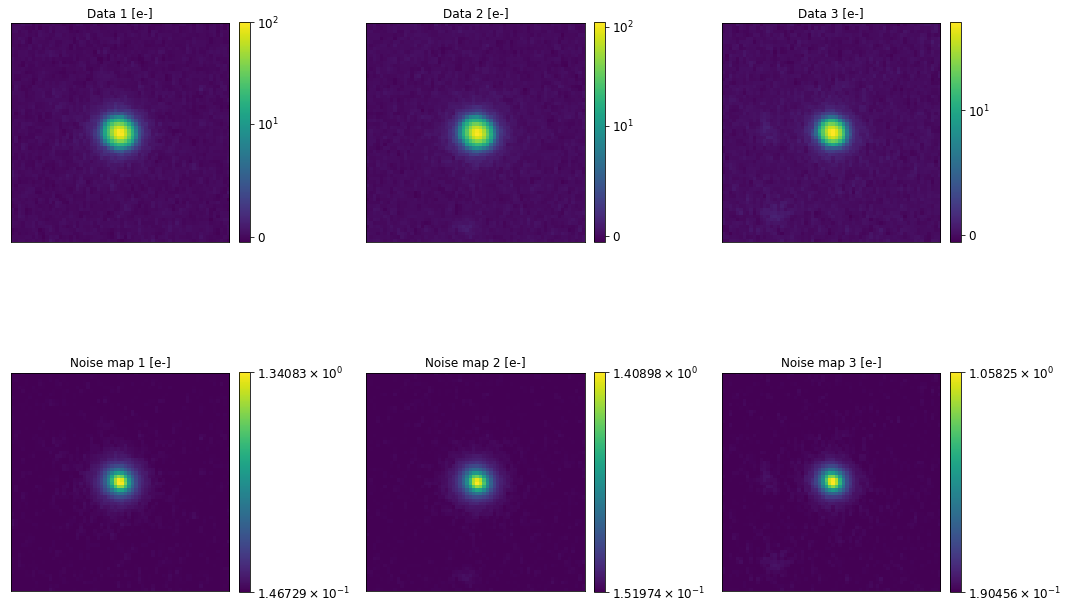

In [44]:
fig=pltf.display_data(new_vignets_data, sigma_2=sigma_2, units='e-')

In [45]:
# Build the PSF model class
model = PSF(image_size=image_size, number_of_sources=N, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat = include_moffat)

# Parameter initialization. 
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model.smart_guess(new_vignets_data, fixed_background=True)

print('Initial Guess :', kwargs_init) 

parameters = ParametersPSF(model, kwargs_init, kwargs_fixed, kwargs_up=kwargs_up, kwargs_down=kwargs_down)

Initial Guess : {'kwargs_moffat': {'fwhm': 3.0, 'beta': 2.0, 'C': 172.89277610768798}, 'kwargs_gaussian': {'a': DeviceArray([1., 1., 1.], dtype=float64), 'x0': array([-1.,  0.,  0.]), 'y0': array([-1., -1., -1.])}, 'kwargs_background': {'background': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


In [46]:
# Moffat fitting and amplitude tunning 
loss = Loss(new_vignets_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet', 
            regularization_strength_scales=0, regularization_strength_hf=0) 
optim = Optimizer(loss, parameters, method=method_analytical)

optimiser_scipy_option = {'maxiter':n_iter_initial, 'restart_from_init':True, 'use_grad':True, 'use_hessian':False, 'use_hvp':True}

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_scipy_option)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +3.4272e+04 | 1.00e+00 | 3.04e+04 | 0.00e+00 |
|   2   |   2   |   2   | +1.7022e+04 | 7.00e+00 | 7.20e+03 | 0.00e+00 |
|   3   |   3   |   9   | +1.7022e+04 | 7.19e-01 | 7.20e+03 | 0.00e+00 |
|   4   |   4   |  10   | +1.1415e+04 | 5.03e+00 | 5.63e+03 | 0.00e+00 |
|   5   |   5   |  19   | +5.9727e+03 | 1.01e+01 | 1.06e+04 | 0.00e+00 |
|   6   |   6   |  26   | +4.0623e+03 | 7.04e+01 | 1.62e+03 | 0.00e+00 |
|   7   |   7   |  33   | +4.0623e+03 | 7.04e+00 | 1.62e+03 | 0.00e+00 |
|   8   |   8   |  40   | +3.5939e+03 | 4.93e+01 | 4.27e+02 | 0.00e+00 |
|   9   |   9   |  50   | +2.8214e+03 | 7.31e+01 | 2.12e+03 | 1.68e+00 |
|  10   |  11   |  62   | +2.8214e+03 | 7.31e+00 | 2.12e+03 | 1.68e+00 |
|  11   |  12   |  71   | +2.8214e+03 | 7.31e-01 | 2.12e+03 | 1.68e+00 |
|  12   |  13   |  76   | +2.6579e+03 | 5.11e+00 | 

Moffat fit : {'kwargs_moffat': {'fwhm': array([3.54344424]), 'beta': array([2.10782487]), 'C': array([115.30478698])}, 'kwargs_gaussian': {'a': array([-0.48029404, -0.55883425, -0.33968328]), 'x0': array([-0.26199986,  0.52001906,  0.31850807]), 'y0': array([-0.03379778, -0.12634859,  0.06106667])}, 'kwargs_background': {'background': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


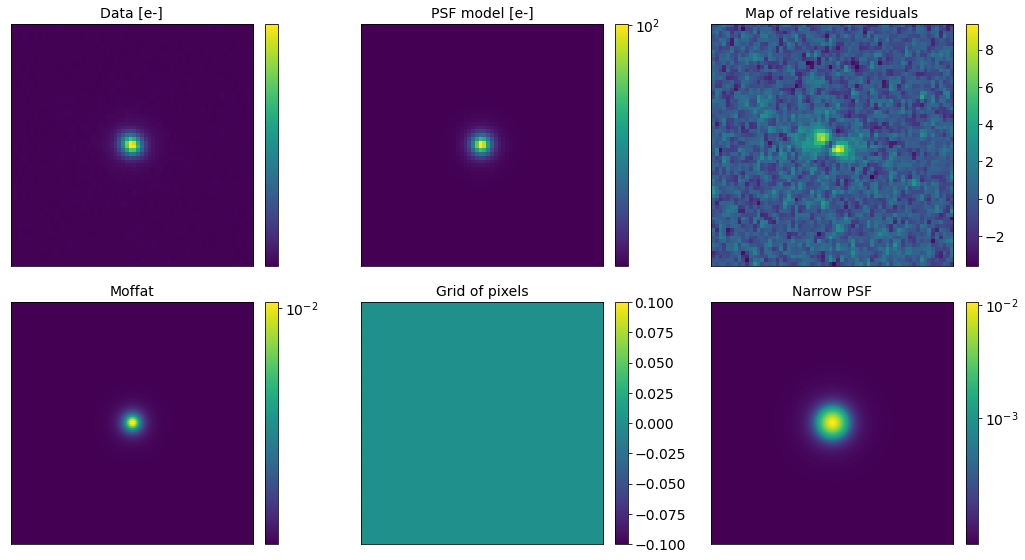

In [47]:
# Printing partial results
kwargs_partial = parameters.args2kwargs(best_fit)
print('Moffat fit :',kwargs_partial) 

fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_partial, n_psf=0, units='e-')

0.4616923583734067
0.10421289495520313
0.044314383947440396
0.02122279184301186
0.010392483774762758
0.00508371562139401
0.002527087790015226
0.0012870537726584908


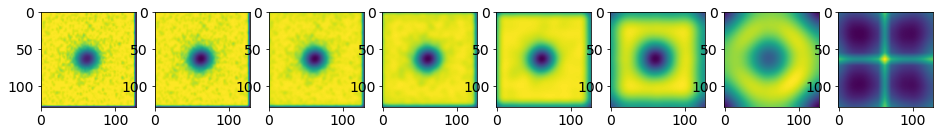

In [48]:
# compute noise level in starlet space, also propagate poisson noise
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_partial, wavelet_type_list=['starlet'], method='SLIT', num_samples=5000,
             seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor)[0]

#This is a representation of your noise level (background + Poisson) in the different starlet scales
gix, axs = plt.subplots(1, len(W), figsize=(16, 4))
for i, l in enumerate(W):
    axs[i].imshow(l)
    print(np.mean(l))
plt.show()
# You can save these noise maps to avoid recomputation
#np.save('./input/W_SLIT_chi2.npy', W)

In [49]:
# Release backgound, fix the moffat
kwargs_fixed = {
    'kwargs_moffat': {'fwhm': kwargs_partial['kwargs_moffat']['fwhm'], 'beta': kwargs_partial['kwargs_moffat']['beta'], 'C':kwargs_partial['kwargs_moffat']['C']},
    'kwargs_gaussian': {},
    'kwargs_background': {},
}

parameters = ParametersPSF(model, kwargs_partial, kwargs_fixed, kwargs_up, kwargs_down)

loss = Loss(new_vignets_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet',
            regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
            regularization_strength_positivity=lambda_positivity, W=W, regularize_full_psf=regularize_full_psf)


optim = Optimizer(loss, parameters, method=method)
optimiser_optax_option = {
                            'max_iterations':n_iter, 'min_iterations':None,
                            'init_learning_rate':1e-2, 'schedule_learning_rate':True,
                            'restart_from_init':False, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                        }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)

optax.adabelief: 100%|██████████| 300/300 [00:05<00:00, 52.17it/s]


{'kwargs_moffat': {'fwhm': array([3.54344424]), 'beta': array([2.10782487]), 'C': array([115.30478698])}, 'kwargs_gaussian': {'a': DeviceArray([-0.51939603, -0.54677167, -0.30913621], dtype=float64), 'x0': DeviceArray([-0.2204259 ,  0.5624105 ,  0.35128884], dtype=float64), 'y0': DeviceArray([-0.05848831, -0.14496979,  0.0411317 ], dtype=float64)}, 'kwargs_background': {'background': DeviceArray([ 5.02887656e-04,  5.76555719e-03,  3.63373627e-03, ...,
             -3.84479906e-01, -1.95923462e-01, -7.62020589e-01],            dtype=float64)}}
Overall Reduced Chi2 :  0.7325391325992812
Loss :  1746.7246663260769
Log Likelihood :  -1500.2401435633278
Log Regul :  -246.484522762749
Log regul positivity : -0.0


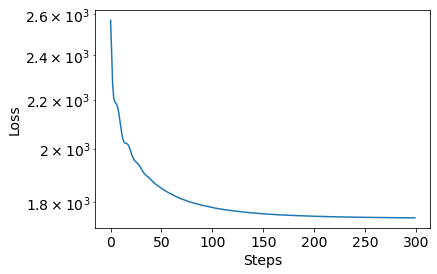

In [50]:
kwargs_final = parameters.args2kwargs(best_fit)
print(kwargs_final)

loss_history = extra_fields['loss_history']
param_history = extra_fields['param_history']

plt.plot(range(n_iter), loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')

print('Overall Reduced Chi2 : ', -2 * loss._log_likelihood_chi2(kwargs_final) / (image_size**2) )
print('Loss : ', loss.loss(best_fit))
print('Log Likelihood : ', loss._log_likelihood(kwargs_final))
print('Log Regul : ', loss._log_regul(kwargs_final))
print('Log regul positivity :', loss._log_regul_positivity(kwargs_final))

In [51]:
# Example on how to retrieve different elements of the PSF 
n_psf = 0
estimated_full_psf = model.model(n_psf, **kwargs_final)
analytic = model.get_moffat(kwargs_final['kwargs_moffat'], norm=True)
s = model.get_narrow_psf(**kwargs_final, norm=True)
background = model.get_background(kwargs_final['kwargs_background'])

dif = new_vignets_data[n_psf,:,:] - estimated_full_psf
rr = np.abs(dif) / np.sqrt(sigma_2[n_psf,:,:])

dif = new_vignets_data[n_psf,:,:] - estimated_full_psf
rr = np.abs(dif) / np.sqrt(sigma_2[n_psf,:,:])

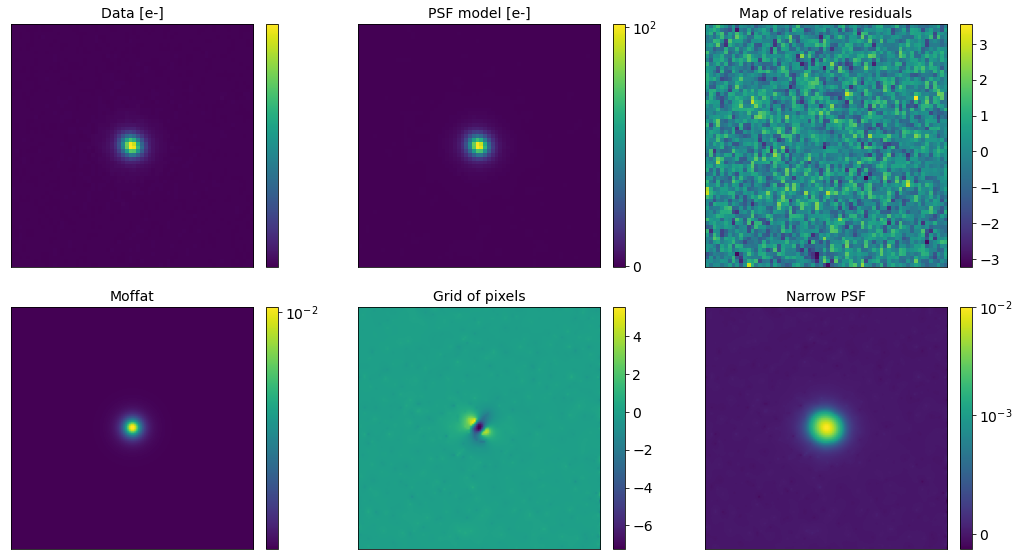

In [52]:
fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final, n_psf=0, units='e-')

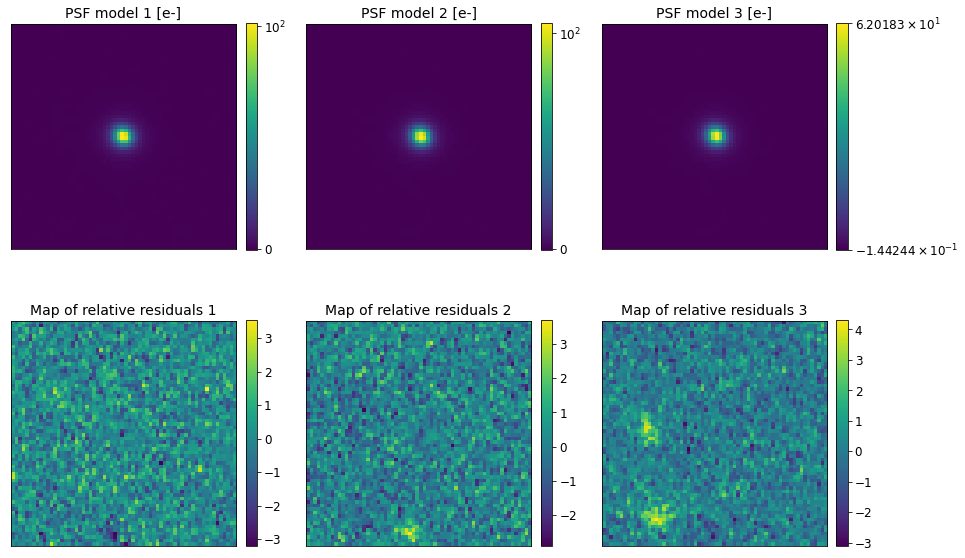

In [53]:
fig3 = pltf.multiple_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final, units='e-')

In [54]:
# Uncomment the following lines to save the obtained narrow PSF
#output_folder = 'output/'
#
#model.export(output_folder, kwargs_final, new_vignets_data, sigma_2, format='fits')
#model.dump(os.path.join(output_folder, 'model.pkl'), kwargs_final, norm) 

astrometry = model.get_astrometry(**kwargs_final)
photometry = model.get_photometry(**kwargs_final) * norm 
photometry_highres = model.get_photometry(**kwargs_final, high_res=True) * norm / subsampling_factor**2 # photometry on the subsampled PSF

print('Astrometry :', np.asarray(astrometry))
print('Photometry :', np.asarray(photometry))
print('Photometry high resolution :', np.asarray(photometry_highres))

Astrometry : [[-0.2204259  -0.05848831]
 [ 0.5624105  -0.14496979]
 [ 0.35128884  0.0411317 ]]
Photometry : [164900.83305194 173552.3390523   98137.7994369 ]
Photometry high resolution : [164900.83305194 173552.3390523   98137.7994369 ]
